# Modelo de Regressão VAR

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling as ProfileReport
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
df_caminhoes = pd.read_excel("C:/Users/User/Downloads/auto e caminhoes fenabrave.xlsx")
df_energia = pd.read_excel("C:/Users/User/Downloads/consumo de energia.xlsx")

In [4]:
df_caminhoes =df_caminhoes.iloc[7:,0:3].head(10)

In [6]:
df_caminhoes = df_caminhoes.rename(columns=df_caminhoes.iloc[0]).drop(df_caminhoes.index[0]).reset_index(drop=True)

In [7]:
df_energia = df_energia.iloc[7:].reset_index(drop = True)

In [8]:
df_energia.columns = df_energia.iloc[0,:]

In [9]:
df_energia = df_energia.iloc[1:]

In [13]:
df_energia.rename(columns = {'Nome da serie':'Data'},inplace = True)
df_caminhoes.rename(columns = {'Nome da serie':'Data'},inplace = True)

In [16]:
df_energia['Data'] = [pd.to_datetime(i) for i in df_energia['Data']]
df_caminhoes['Data'] = [pd.to_datetime(i) for i in df_caminhoes['Data']]

In [17]:
PIB = pd.read_excel('D:/我的/PIB_IPCA.xlsx','PIB')
IPCA = pd.read_excel('D:/我的/PIB_IPCA.xlsx','IPCA')

In [18]:
PIB['Data'] = [i.replace('.','-') for i in PIB['Data']]
PIB['Data'] = [pd.to_datetime(i) for i in PIB['Data']]
PIB = PIB.iloc[:,:2]

In [19]:
IPCA['Data'] = [i.replace('.','-') for i in IPCA['Data']]
IPCA['Data'] = [pd.to_datetime(i) for i in IPCA['Data']]
IPCA = IPCA.iloc[:,:2]

In [20]:
import math
PIB['Estação'] = [math.ceil(int(i.strftime('%m'))/3) for i in PIB['Data']]
IPCA['Estação'] = [math.ceil(int(i.strftime('%m'))/3) for i in IPCA['Data']]

In [21]:
PIB_REAL = pd.merge(PIB,IPCA)

In [22]:
df_energia = pd.merge(pd.merge(df_energia,PIB),IPCA)

In [73]:
df_energia.dtypes

Data                               datetime64[ns]
Consumo de Energia Nacional               float64
Consumo de Energia Centro-Oeste            object
Consumo de Energia Sul                     object
Consumo de Energia Sudeste                 object
Consumo de Energia Norte                   object
Consumo de Energia Nordeste                object
PIB                                       float64
Estação                                     int64
IPCA                                      float64
PIB_Var                                   float64
Consumo de Energia Nacional Var           float64
dtype: object

In [68]:
df_energia['Consumo de Energia Nacional'] = pd.to_numeric(df_energia['Consumo de Energia Nacional'])

In [32]:
df_energia.rename(columns = {'Consumo de Energia Elétrica Total (EPE)(Nacional)(Original)(Mensal)(Nível)': 'Consumo de Energia Nacional','Consumo de Energia Elétrica Total (EPE)(Região Centro-oeste)(Original)(Mensal)(Nível)':'Consumo de Energia Centro-Oeste','Consumo de Energia Elétrica Total (EPE)(Região Sul)(Original)(Mensal)(Nível)':'Consumo de Energia Sul','Consumo de Energia Elétrica Total (EPE)(Região Sudeste)(Original)(Mensal)(Nível)':'Consumo de Energia Sudeste','Consumo de Energia Elétrica Total (EPE)(Região Norte)(Original)(Mensal)(Nível)':'Consumo de Energia Norte','Consumo de Energia Elétrica Total (EPE)(Região Nordeste)(Original)(Mensal)(Nível)':'Consumo de Energia Nordeste'},inplace=True)

In [144]:
df_energia

,Data,Consumo de Energia Nacional,Consumo de Energia Centro-Oeste,Consumo de Energia Sul,Consumo de Energia Sudeste,Consumo de Energia Norte,Consumo de Energia Nordeste,PIB,Estação,IPCA,PIB_Var,Consumo de Energia Nacional Var,IPCA_Var
0,2004-01-01,2.697836e+07,1507173.86,4510113.04,14929524.4,1574434.34,4457112.38,144558.6,1,6.04,NaN,NaN,NaN
1,2004-02-01,2.650817e+07,1456012.81,4690227.86,14714713.51,1507448.59,4139768.0,142861.3,1,5.60,-1697.3,-470187.250,-0.44
2,2004-03-01,2.728433e+07,1534843.53,4898770.4,14903795.68,1574176.69,4372743.11,157363.5,1,5.66,14502.2,776158.640,0.06
3,2004-04-01,2.804618e+07,1610686.661,4873311.14,15501322.96,1598862.11,4461999.48,156953.9,2,5.85,-409.6,761852.941,0.19
4,2004-05-01,2.724451e+07,1565788.16,4723026.16,14906628.72,1625478.92,4423584.52,159498.9,2,6.42,2545.0,-801675.871,0.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2021-08-01,4.062858e+07,3229521.63,7578668.669,19567126.511,3161464.87,7091793.35,739692.2,3,5.43,-4466.0,687733.190,0.67
212,2021-09-01,4.198532e+07,3552433.54,7354639.471,20710207.661,3190894.8,7177144.14,731334.1,3,5.78,-8358.1,1356744.582,0.35
213,2021-10-01,4.262215e+07,3600279.44,7451533.11,20798024.23,3219121.3,7553190.45,739982.7,4,6.45,8648.6,636828.918,0.67
214,2021-11-01,4.193184e+07,3364580.54,7615013.091,20301925.39,3178834.95,7471483.22,755731.3,4,6.16,15748.6,-690311.339,-0.29


In [26]:
%matplotlib inline 

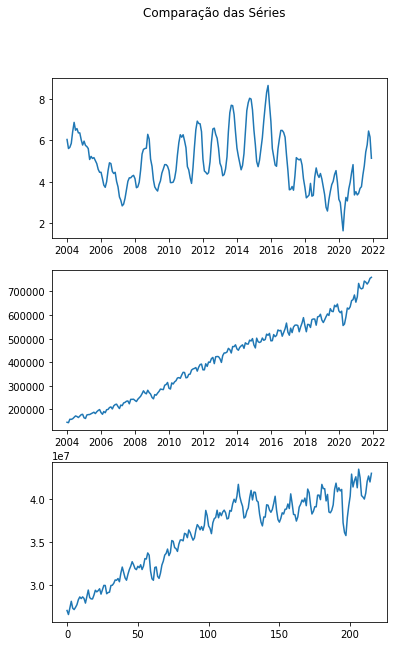

In [69]:
fig, axs = plt.subplots(3,figsize=(6,10))
fig.suptitle('Comparação das Séries')
axs[0].plot(df_energia['Data'], df_energia['IPCA'])
axs[1].plot(df_energia['Data'],df_energia['PIB'])
axs[2].plot(df_energia.index,df_energia['Consumo de Energia Nacional'])

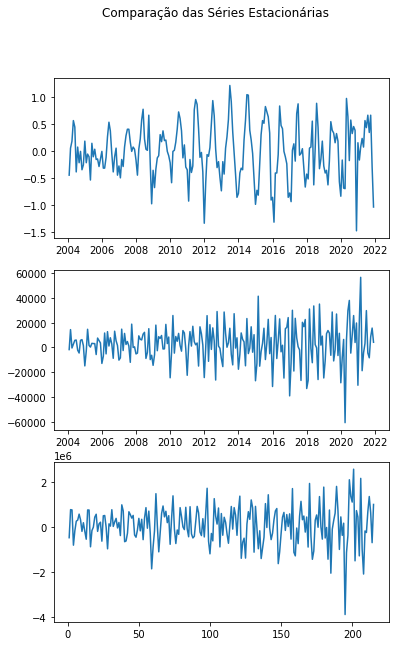

In [77]:
fig, axs = plt.subplots(3,figsize=(6,10))
fig.suptitle('Comparação das Séries Estacionárias')
axs[0].plot(df_energia['Data'], df_energia['IPCA'].diff())
axs[1].plot(df_energia['Data'],df_energia['PIB'].diff())
axs[2].plot(df_energia.index,df_energia['Consumo de Energia Nacional'].diff())

In [71]:
df_energia['Consumo de Energia Nacional Var'] = df_energia['Consumo de Energia Nacional'] - df_energia['Consumo de Energia Nacional'].shift(1) 

In [72]:
df_energia['PIB_Var'] = df_energia['PIB'] - df_energia['PIB'].shift(1)   

In [76]:
df_energia[['Consumo de Energia Nacional','IPCA','PIB']].corr()

,Consumo de Energia Nacional,IPCA,PIB
Consumo de Energia Nacional,1.000000,-0.012009,0.933297
IPCA,-0.012009,1.000000,-0.101260
PIB,0.933297,-0.101260,1.000000


#  Segundo a Macroeconomia...
### Consumo = Co + C1*(Ydisponível)
### Ydisponível = C + I + G + (X - M)
### Ambas variáveis se afetam simultaneamente!

Ao analisar o gráfico do IPCA, ele não aparenta possuir nenhuma tendência específica, portanto optamos por não colocá-lo na primeira diferença. Vamos, porém, realizar o teste adfuller para descobrir se vale ou não a pena realizar esse procedimeto!

In [97]:
ad_fuller_result_1 = adfuller(df_energia['Consumo de Energia Nacional Var'][1:])
ad_fuller_result_2 = adfuller(df_energia['IPCA'])
ad_fuller_result_3 = adfuller(df_energia['PIB_Var'][1:])

Ad_fuller = pd.DataFrame({'Energia Consumo':[ad_fuller_result_1[0],ad_fuller_result_1[1]],'IPCA':[ad_fuller_result_2[0],ad_fuller_result_2[1]], 'PIB':[ad_fuller_result_3[0],ad_fuller_result_3[1]]})
Ad_fuller.rename(index={0:'ADF Statistic',1:'p-value'},inplace=True)

Ad_fuller

,Energia Consumo,IPCA,PIB
ADF Statistic,-4.421987,-2.498599,-4.302433
p-value,0.000271,0.115816,0.000440


O IPCA aparenta não ser estacionário, vamos colocá-lo na primeira diferença para que ele se torne!

In [98]:
df_energia['IPCA_Var'] = df_energia['IPCA'].diff()

## Teste de Causalidade de Granger para ver quais variáveis afetam o Consumo de Energia

In [103]:
print('O Consumo de Energia Afeta o PIB?\n')
print('-------------------------------')
granger_1 = grangercausalitytests(df_energia[['PIB_Var','Consumo de Energia Nacional Var']][1:],2)
print('\n-------------------------------\n')
print('PIB Afeta o Consumo de Energia?\n')
print('-------------------------------')
granger_2 = grangercausalitytests(df_energia[['Consumo de Energia Nacional Var','PIB_Var']][1:],2)
print('\n-------------------------------\n')
print('IPCA Afeta o Consumo de Energia?\n')
print('-------------------------------')
granger_2 = grangercausalitytests(df_energia[['Consumo de Energia Nacional Var','IPCA_Var']][1:],2)
print('\n-------------------------------\n')
print('O Consumo de Energia Afeta o IPCA?\n')
print('-------------------------------')
granger_2 = grangercausalitytests(df_energia[['IPCA_Var','Consumo de Energia Nacional Var']][1:],2)



O Consumo de Energia Afeta o PIB?

-------------------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2123  , p=0.0135  , df_denom=211, df_num=1
ssr based chi2 test:   chi2=6.3006  , p=0.0121  , df=1
likelihood ratio test: chi2=6.2096  , p=0.0127  , df=1
parameter F test:         F=6.2123  , p=0.0135  , df_denom=211, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.8190  , p=0.0014  , df_denom=208, df_num=2
ssr based chi2 test:   chi2=13.9658 , p=0.0009  , df=2
likelihood ratio test: chi2=13.5271 , p=0.0012  , df=2
parameter F test:         F=6.8190  , p=0.0014  , df_denom=208, df_num=2

-------------------------------

PIB Afeta o Consumo de Energia?

-------------------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2536  , p=0.0404  , df_denom=211, df_num=1
ssr based chi2 test:   chi2=4.3141  , p=0.0378  , df=1
likelihood ratio test: chi2=4.2712  , p=0.0388  , df=1
p

### Foi possível verificar que não há uma relação muito significativa do IPCA com a nossa variável principal de interesse do estudo (Consumo de Energia Elétrica), no primeiro LAG como consequência disso, iremos retirá-la do modelo.

# Agora, vamos separar o nosso modelo em Treino e Teste!

In [107]:
train_df = df_energia[['PIB','Consumo de Energia Nacional']][:-24]
test_df = df_energia[['PIB','Consumo de Energia Nacional']][-24:]

In [108]:
model = VAR(train_df.diff()[1:])
sorted_order = model.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        46.29       46.33   1.275e+20       46.31
1        46.23       46.34   1.195e+20       46.27
2        45.97       46.15   9.209e+19       46.04
3        45.79       46.05   7.702e+19       45.89
4        45.76       46.09   7.500e+19       45.90
5        45.57       45.98   6.186e+19       45.74
6        45.37       45.84   5.040e+19       45.56
7        45.29       45.84   4.678e+19       45.51
8        45.18       45.81   4.208e+19       45.44
9        45.13       45.83   3.994e+19       45.42
10       45.04       45.81   3.630e+19       45.35
11       44.82       45.67   2.933e+19       45.16
12       44.74       45.66   2.697e+19       45.11
13       44.66      45.65*   2.505e+19      45.06*
14       44.66       45.72   2.494e+19       45.09
15       44.68       45.82   2.567e+19       45.15
16       44.65       45.87   2.

d:\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


## Nesse gráfico, é possível verificar que o modelo está nos recomendando utilizar um total de 17 Lags em 2 das colunas, o que é o que iremos fazer!

In [198]:
var_model = VARMAX(train_df,order =(17,0), enforce_stationarity=True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     Statespace Model Results                                     
Dep. Variable:     ['PIB', 'Consumo de Energia Nacional']   No. Observations:                  192
Model:                                            VAR(17)   Log Likelihood               -6367.855
                                              + intercept   AIC                          12881.709
Date:                                    Sun, 06 Mar 2022   BIC                          13119.506
Time:                                            20:10:12   HQIC                         12978.019
Sample:                                                 0                                         
                                                    - 192                                         
Covariance Type:                                      opg                                         
Ljung-Box (L1) (Q):         114.13, 140.67   Jarque-Bera (JB):         202.44, 0.71
Prob(Q):                 

In [199]:
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + 24 -1)
predictions = predict.predicted_mean

In [200]:
predictions.rename(columns = {'PIB':'PIB_Forecast','Consumo de Energia Nacional':'Consumo de Energia Nacional_Forecast'},inplace=True)

In [201]:
test_vs_pred = pd.concat([test_df['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast']],axis=1)

<AxesSubplot:>

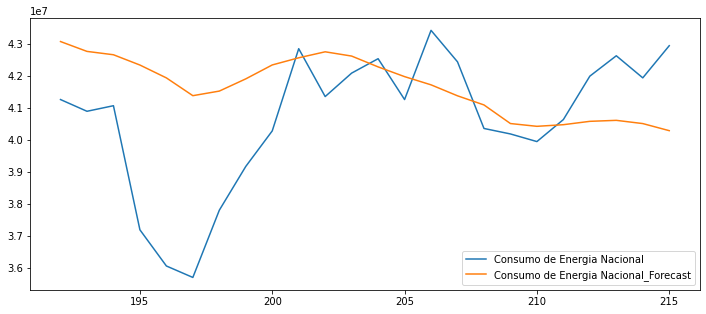

In [202]:
test_vs_pred.plot(figsize=(12,5))

In [205]:
pd.DataFrame({'MSE':[mean_squared_error(test_df['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast'])/10**10],'MAE':[mean_absolute_error(test_df['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast'])/10**6]},index=['VAR'])

,MSE,MAE
VAR,630.067564,1.902743


## Realizando o teste do melhor modelo LEVANDO EM CONSIDERAÇÃO APENAS OS CRITÉRIOS BÁSICOS DE MAE e MSE

In [160]:
l = []
for i in range(1,18):
    if i != 7:
        var_model = VARMAX(train_df,order =(i,0), enforce_stationarity=True)
        fitted_model = var_model.fit(disp=False)
        predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + 24 -1)
        predictions = predict.predicted_mean
        predictions.rename(columns = {'PIB':'PIB_Forecast','Consumo de Energia Nacional':'Consumo de Energia Nacional_Forecast'},inplace=True)
        print(f"MAE: {mean_absolute_error(test_df['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast'])/10**6}")
        print(f"MSE: {mean_squared_error(test_df['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast'])/10**6}")
        l.append({f'{i} LAGs:':[mean_absolute_error(test_df['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast'])/10**6,mean_squared_error(test_df['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast'])/10**10]})

MAE: 1.6018943031315946
MSE: 5276503.329718743
MAE: 1.61162695369461
MSE: 5334189.465640106


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


MAE: 2.068655953144419
MSE: 7593467.586692094


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 2.053715984900794
MSE: 7872186.210517305


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 2.242317278045643
MSE: 9683344.576813491


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 1.6985185841253754
MSE: 5090574.383250363


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 1.6935115473102003
MSE: 4838019.533562556


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 1.483489675051585
MSE: 4026485.5217817384


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 2.460030992945715
MSE: 11338718.495673236


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 2.717489437024455
MSE: 14434055.863413123


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 3.4622296058056405
MSE: 18281956.42125098


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 3.0716021355021446
MSE: 14187722.267229125


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


MAE: 5.391160003853566
MSE: 33406901.279443253


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 2.328108110911928
MSE: 9617033.015237221


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 2.460258658160197
MSE: 9807252.42734307


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 1.9027433905597364
MSE: 6300675.641975816


In [161]:
l

[{'1 LAGs:': [1.6018943031315946, 527.6503329718743]},
 {'2 LAGs:': [1.61162695369461, 533.4189465640106]},
 {'3 LAGs:': [2.068655953144419, 759.3467586692094]},
 {'4 LAGs:': [2.053715984900794, 787.2186210517305]},
 {'5 LAGs:': [2.242317278045643, 968.334457681349]},
 {'6 LAGs:': [1.6985185841253754, 509.05743832503634]},
 {'8 LAGs:': [1.6935115473102003, 483.8019533562556]},
 {'9 LAGs:': [1.483489675051585, 402.6485521781738]},
 {'10 LAGs:': [2.460030992945715, 1133.8718495673236]},
 {'11 LAGs:': [2.717489437024455, 1443.4055863413123]},
 {'12 LAGs:': [3.4622296058056405, 1828.195642125098]},
 {'13 LAGs:': [3.0716021355021446, 1418.7722267229126]},
 {'14 LAGs:': [5.391160003853566, 3340.6901279443255]},
 {'15 LAGs:': [2.328108110911928, 961.7033015237221]},
 {'16 LAGs:': [2.460258658160197, 980.725242734307]},
 {'17 LAGs:': [1.9027433905597364, 630.0675641975816]}]

## Depois de testar, vamos ver o quanto nosso modelo acertou em um gráfico!

d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


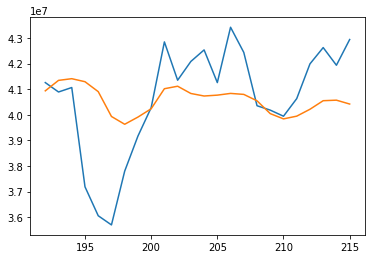

In [195]:
var_model = VARMAX(train_df,order =(9,0), enforce_stationarity=True)
fitted_model = var_model.fit(disp=False)
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + 24 -1)
predictions = predict.predicted_mean
predictions.rename(columns = {'PIB':'PIB_Forecast','Consumo de Energia Nacional':'Consumo de Energia Nacional_Forecast'},inplace=True)
test_vs_pred_após_teste = pd.concat([test_df['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast']],axis=1)
plt.plot(test_vs_pred_após_teste)

## Agora, vamos utilizar 9 LAGs para obter as nossas estimativas para o Consumo de Energia no Futuro ;)

In [182]:
var_model = VARMAX(df_energia[['PIB','Consumo de Energia Nacional']],order =(9,0), enforce_stationarity=True)
fitted_model = var_model.fit(disp=False)
predict = fitted_model.get_prediction(start=len(df_energia),end=len(df_energia) + 24 -1)
predictions = predict.predicted_mean
predictions.rename(columns = {'PIB':'PIB_Forecast','Consumo de Energia Nacional':'Consumo de Energia Nacional_Forecast'},inplace=True)

d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Agora vamos ver como nossas estimativas ficaram, tanto em um DataFrame quanto em um gráfico (Bem mais Visual!)

In [192]:
pd.set_option('display.max_rows',300)

In [193]:
pd.DataFrame(pd.concat([df_energia['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast']])/10**6,columns=['Estimativas'])

,Estimativas
0,26.978358
1,26.508171
2,27.284329
3,28.046182
4,27.244506
5,27.082961
6,27.346005
7,27.656858
8,28.232451
9,28.556121


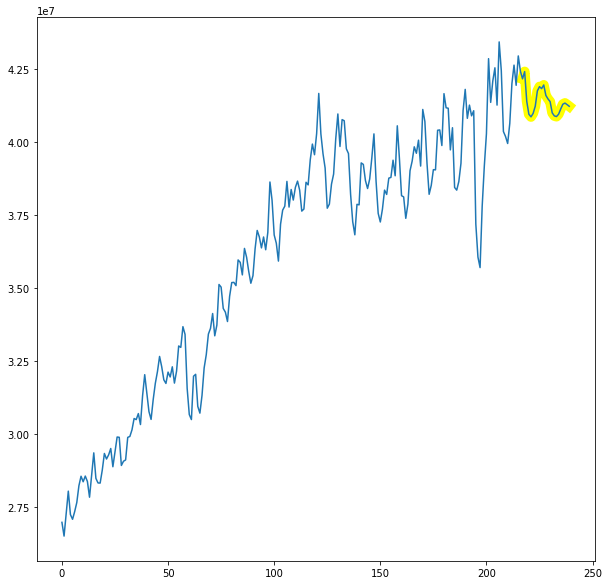

In [183]:
Forecast = pd.concat([df_energia['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast']])
fig, axs = plt.subplots(1,figsize=(10,10))
axs.plot(Forecast[217:240], lw=10, c='yellow', zorder=-1)
axs.plot(Forecast)
